## Unveiling Musical Patterns: Song Analysis and Likeness Prediction

Description: Spotify Web API enables the creation of applications that can interact with Spotify's streaming service, such as retrieving content metadata, getting recommendations, creating and managing playlists, or controlling playback.

### Summary

[The data](https://developer.spotify.com/documentation/web-api) will be accessed through Spotify.

### Importing Libraries

In [122]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import sys
from pycaret.clustering import ClusteringExperiment
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pycaret.classification import setup, compare_models, pull, save_model
import time

### Getting Data from API

In [132]:
# Replace YOUR_CLIENT_ID, YOUR_CLIENT_SECRET, and YOUR_REDIRECT_URI with your credentials
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='2b515c69e6d541daa25d644bb844de11',
                                               client_secret='654ce05e3e19462c8964065e3887b80f',
                                               redirect_uri='http://localhost:8080',
                                               scope='user-library-read'))

# Lists to store song names, artist names, and song details
song_names = []
artist_names = []
song_details = []

# Set the number of songs you want to retrieve (in this case, 700)
desired_number_of_songs = 100
songs_per_request = 50

while len(song_names) < desired_number_of_songs:
    remaining_songs = desired_number_of_songs - len(song_names)
    current_limit = min(remaining_songs, songs_per_request)

    results = sp.current_user_saved_tracks(limit=current_limit, offset=len(song_names))

    if len(results['items']) == 0:
        # No more songs to retrieve
        break

    for item in results['items']:
        track = item['track']
        song_names.append(track['name'])
        artist_names.append(track['artists'][0]['name'])
        song_details.append(track['id'])  # Store the track ID for getting details later
        print(track['name'], track['artists'][0]['name'])

    # Sleep for 45 seconds before the next batch request
    time.sleep(30)

New Fires Christian Löffler
Welcome To The Opera (with Grimes) Anyma
How To Listen To This Album Stereoclip
Moment - Mahmut Orhan Remix PaulWetz
Sign of the Times Harry Styles
Delichones Anatolian Sessions
Elinari Anatolian Sessions
Elegy Madota
Caminando de Noche Niko Schwind
Only We Can See Sam Koxx
Vesaire - Sezer Uysal Mix Mahmut Orhan
Ordinary Friend Bob Moses
Before I Fall Bob Moses
Time and Time Again - Single Edit Bob Moses
Afterglow Bob Moses
Danza Anfisa Letyago
Rosso Profondo Anfisa Letyago
Tears of Bliss Giorgia Angiuli
Outomorrow - Anyma, Kevin de Vries Remix KAS:ST
Quiet Distortion - Bart Skils Remix Gregor Tresher
Too Little Too Late - Little Late Edit Joris Voorn
Paradise - Âme Remix mOat
Self Control Laura Branigan
Suçlarımdan Biri Güneş
Mektup Motive
Paranoya UZI
Umutsuz Aşk Sözlü - Yalı Çapkını Original Soundtrack Güldiyar Tanrıdağlı
Kalmak Daha Zor Güneş
Shades Of Night Einmusik
All You Leave Behind Ross Tones
Diet Mountain Dew Lana Del Rey
Claire Anyma
Consciousnes

In [ ]:
# Get detailed information for each song using the audio_features endpoint
song_audio_features = sp.audio_features(tracks=song_details)

# Create the DataFrame
df = pd.DataFrame({'Song': song_names, 'Artist': artist_names, 'Details': song_audio_features})
df

In [ ]:
# Use the apply method to create separate columns for each audio feature
df = pd.concat([df.drop(['Details'], axis=1), df['Details'].apply(pd.Series)], axis=1)

### Clustering (k-means)

In [ ]:
# Initialize the ClusteringExperiment and set up the environment
s = ClusteringExperiment()
s.setup(df, normalize = True)

,Description,Value
0,Session id,4454
1,Original data shape,"(50, 20)"
2,Transformed data shape,"(50, 303)"
3,Numeric features,13
4,Categorical features,7
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Maximum one-hot encoding,-1


In [ ]:
# Create a KMeans clustering model
kmeans = s.create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Evaluate the KMeans model using internal metrics
s.evaluate_model(kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

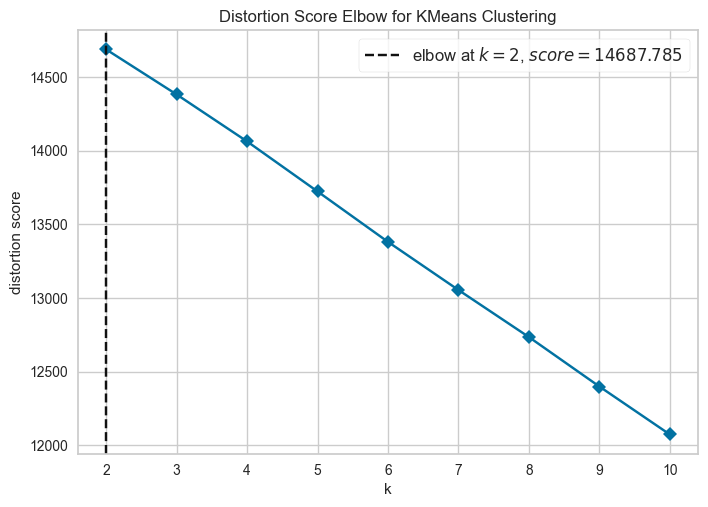

In [ ]:
# Plot the Elbow plot to find the optimal number of clusters
s.plot_model(kmeans, plot = 'elbow')

In [ ]:
# Assign clusters to the data using the KMeans model
result = s.assign_model(kmeans)
result.head()

,Song,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Cluster
0,New Fires,Christian Löffler,0.712,0.569,6,-10.819,0,0.0348,0.3460,0.492,...,0.2410,116.015999,audio_features,6I7nESv5d9zf9DcEA9I25u,spotify:track:6I7nESv5d9zf9DcEA9I25u,https://api.spotify.com/v1/tracks/6I7nESv5d9zf...,https://api.spotify.com/v1/audio-analysis/6I7n...,251591,4,Cluster 3
1,Welcome To The Opera (with Grimes),Anyma,0.455,0.897,5,-6.345,0,0.0507,0.0073,0.259,...,0.0578,124.976997,audio_features,3XgtRplaKaBn8lxBCAhfwI,spotify:track:3XgtRplaKaBn8lxBCAhfwI,https://api.spotify.com/v1/tracks/3XgtRplaKaBn...,https://api.spotify.com/v1/audio-analysis/3Xgt...,245280,4,Cluster 3
2,How To Listen To This Album,Stereoclip,0.551,0.712,9,-10.032,0,0.0514,0.2850,0.440,...,0.0746,123.058998,audio_features,0Py4iHLT1CPUOB6UJCrKeq,spotify:track:0Py4iHLT1CPUOB6UJCrKeq,https://api.spotify.com/v1/tracks/0Py4iHLT1CPU...,https://api.spotify.com/v1/audio-analysis/0Py4...,150462,4,Cluster 3
3,Moment - Mahmut Orhan Remix,PaulWetz,0.814,0.518,1,-9.994,0,0.0751,0.1410,0.415,...,0.3270,123.028999,audio_features,3M6U1RZt2xU6GuVk80pIO0,spotify:track:3M6U1RZt2xU6GuVk80pIO0,https://api.spotify.com/v1/tracks/3M6U1RZt2xU6...,https://api.spotify.com/v1/audio-analysis/3M6U...,230046,4,Cluster 3
4,Sign of the Times,Harry Styles,0.516,0.595,5,-4.630,1,0.0313,0.0275,0.000,...,0.2220,119.972000,audio_features,5Ohxk2dO5COHF1krpoPigN,spotify:track:5Ohxk2dO5COHF1krpoPigN,https://api.spotify.com/v1/tracks/5Ohxk2dO5COH...,https://api.spotify.com/v1/audio-analysis/5Ohx...,340707,4,Cluster 2


### Clustering (dbscan)

In [ ]:
# Create a KMeans clustering model
dbscan = s.create_model('dbscan')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
s.evaluate_model(dbscan)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Model Evaluation

In [ ]:
# Create a Spotipy client with authentication
auth_manager = SpotifyClientCredentials(client_id="2b515c69e6d541daa25d644bb844de11", client_secret="654ce05e3e19462c8964065e3887b80f")
sp = spotipy.Spotify(auth_manager=auth_manager)

# Define the artist and song name
artist_name = "Two Us"
song_name = "What's Your Name"

# Search for the song
results = sp.search(q=f"artist:{artist_name} track:{song_name}", type="track", limit=1)

# Check if any results were found
if results["tracks"]["items"]:
    track = results["tracks"]["items"][0]
    track_name = track["name"]
    artist_name = track["artists"][0]["name"]
    album_name = track["album"]["name"]
    
    # Print the basic track information
    print(f"Found: '{track_name}' by '{artist_name}' from the album '{album_name}'")

    # Get the track ID
    track_id = track["id"]

    # Retrieve the audio features for the track
    audio_features = sp.audio_features([track_id])[0]

    # Print the audio features
    print("\nAudio Features:")
    for key, value in audio_features.items():
        print(f"{key}: {value}")
else:
    print("Song not found.")

Found: 'What's Your Name' by 'Us Two' from the album 'What's Your Name'

Audio Features:
danceability: 0.777
energy: 0.802
key: 8
loudness: -9.746
mode: 1
speechiness: 0.0466
acousticness: 0.000495
instrumentalness: 0.64
liveness: 0.0937
valence: 0.632
tempo: 135.006
type: audio_features
id: 2hGFAk0wIN0HYOnKXLopC3
uri: spotify:track:2hGFAk0wIN0HYOnKXLopC3
track_href: https://api.spotify.com/v1/tracks/2hGFAk0wIN0HYOnKXLopC3
analysis_url: https://api.spotify.com/v1/audio-analysis/2hGFAk0wIN0HYOnKXLopC3
duration_ms: 444445
time_signature: 4


In [ ]:
# Create a dictionary to store the track information and audio features
df_test = {
        "Track Name": track_name,
        "Artist Name": artist_name,
        "Album Name": album_name
        }
results.update(audio_features)

# Convert the dictionary to a DataFrame
df_test = pd.DataFrame([results])

# Dropping the "tracks" column
df_test.drop(columns=['tracks'], inplace=True)
df_test

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.777,0.802,8,-9.746,1,0.0466,0.000495,0.64,0.0937,0.632,135.006,audio_features,2hGFAk0wIN0HYOnKXLopC3,spotify:track:2hGFAk0wIN0HYOnKXLopC3,https://api.spotify.com/v1/tracks/2hGFAk0wIN0H...,https://api.spotify.com/v1/audio-analysis/2hGF...,444445,4


In [ ]:
# Add "Song" and "Artist" column
df_test.insert(0, 'Song', "What's Your Name")
df_test.insert(1, 'Artist', "Us Two")

In [ ]:
# Add "Cluster" column
df_test.insert(20, 'Cluster', "")

In [ ]:
# Split the data into features (X) and the target variable (y)
X = result.drop("Cluster", axis=1)
y = result["Cluster"]

# Convert categorical variables into numerical using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=26)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=26)

In [ ]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

   Cluster 0       0.74      1.00      0.85        14
   Cluster 1       1.00      0.50      0.67         2
   Cluster 2       0.00      0.00      0.00         1
   Cluster 3       0.00      0.00      0.00         3

    accuracy                           0.75        20
   macro avg       0.43      0.38      0.38        20
weighted avg       0.62      0.75      0.66        20



In [ ]:
# It turns the categorical variables (like workclass, education, etc.) into numerical values 
df_test = pd.get_dummies(df_test)

# Reorder the columns in test_df to match the order in X_train
df_test = df_test.reindex(columns=X.columns, fill_value=0)

# Make predictions using the trained classifier
predicted_cluster = rf_classifier.predict(df_test)

print("Predicted Cluster:", predicted_cluster[0])

Predicted Cluster: Cluster 0
